In [1456]:
%pylab inline
indir = '/mnt/store1/oliverphilcox/3PCF_SE/3PCFCovMatricesAll/'
n=15
l=0
m=l+1

Populating the interactive namespace from numpy and matplotlib


/home/oliverphilcox/anaconda3/lib/python3.7/site-packages/IPython/core/magics/pylab.py:160: UserWarning: pylab import has clobbered these variables: ['test']
`%matplotlib` prevents importing * from pylab and numpy
  "\n`%matplotlib` prevents importing * from pylab and numpy"


# Must include $(6V(nw)^3)^2$ normalization

In [1861]:
def symmetrize(mat):
    """ Add in symmetries to matrices """
    out_mat = np.zeros_like(mat)
    for i in range(len(mat)//m):
        a = i//n
        b = i%n
        for j in range(len(mat)//m):
            c = j//n
            d = j%n
            # Add to all relevant bins
            these_mat = mat[i*m:(i+1)*m,j*m:(j+1)*m]*0.25
            out_mat[(a*n+b)*m:(a*n+b)*m+m,(c*n+d)*m:(c*n+d)*m+m]+=these_mat
            out_mat[(b*n+a)*m:(b*n+a)*m+m,(c*n+d)*m:(c*n+d)*m+m]+=these_mat
            out_mat[(b*n+a)*m:(b*n+a)*m+m,(d*n+c)*m:(d*n+c)*m+m]+=these_mat
            out_mat[(a*n+b)*m:(a*n+b)*m+m,(d*n+c)*m:(d*n+c)*m+m]+=these_mat
    return 0.5*(out_mat+out_mat.T)

In [1862]:
def plotter(mat):
    vmax=np.percentile(mat,99.)
    plt.matshow(mat,vmax=vmax,vmin=-vmax,cmap=cm.RdBu_r);
    plt.colorbar();
    plt.ylim([-0.5,len(mat)-0.5])
    plt.xlim([-0.5,len(mat)-0.5])

In [1863]:
def rebinner(mat):
    out_mat = np.zeros_like(mat)
    for i in range(m):
        for j in range(m):
            out_mat[i*n*n:(i+1)*n*n,j*n*n:(j+1)*n*n]=mat[i::m,j::m]
    return out_mat

In [1864]:
total_counts = np.loadtxt('/mnt/store1/oliverphilcox/3PCF_SE/3PCFCovMatricesAll/total_counts_n%d_l%d_0.txt'%(n,l))

In [1865]:
print("Triples: %.1e Quads: %.1e, Quints: %.1e, Hexes: %.1e"%(total_counts[0],total_counts[1],total_counts[2],total_counts[3]))

Triples: 2.1e+09 Quads: 8.2e+09, Quints: 3.3e+10, Hexes: 6.6e+10


In [1866]:
bins_r = np.loadtxt('/mnt/store1/oliverphilcox/3PCF/SE_binning_n15.csv')

In [1867]:
print('Radial Bins')
print(bins_r[:,0])
print(bins_r[:,1])
delta_r = bins_r[-1,0]-bins_r[-2,0]

Radial Bins
[ 30.  40.  50.  60.  70.  80.  90. 100. 110. 120. 130. 140. 150. 160.
 170.]
[ 40.  50.  60.  70.  80.  90. 100. 110. 120. 130. 140. 150. 160. 170.
 180.]


In [1868]:
c30=np.loadtxt(indir+'c3_n%d_l%d_0_full.txt'%(n,l))
c40=np.loadtxt(indir+'c4_n%d_l%d_0_full.txt'%(n,l))
c50=np.loadtxt(indir+'c5_n%d_l%d_0_full.txt'%(n,l))
c60=np.loadtxt(indir+'c6_n%d_l%d_0_full.txt'%(n,l))
c31=np.loadtxt(indir+'c3_n%d_l%d_1_full.txt'%(n,l))
c41=np.loadtxt(indir+'c4_n%d_l%d_1_full.txt'%(n,l))
c51=np.loadtxt(indir+'c5_n%d_l%d_1_full.txt'%(n,l))
c61=np.loadtxt(indir+'c6_n%d_l%d_1_full.txt'%(n,l))
c3=c30+c31
c4=c40+c41
c5=c50+c51
c6=c60+c61

In [1869]:
c3s=symmetrize(c3)
c4s=symmetrize(c4)
c5s=symmetrize(c5)
c6s=symmetrize(c6)

In [1870]:
# c3so=c3s
# c4so=c4s
# c5so=c5s
# c6so=c6s
# c6o0=c60
# c6o1=c61

## Use SE compression

In [1871]:
good_r_bins=[]
for b1 in range(n):
    for b2 in range(n):
        r1=bins_r[b1,0]
        r2=bins_r[b2,0]
        if (r2>=3*delta_r) and (r2<r1-3*delta_r):
            good_r_bins.append(b1)
good_r_bins = np.unique(np.asarray(good_r_bins))
n_g = len(good_r_bins)
min_r_bin = min(good_r_bins)

In [1872]:
def compression(mat):
    comp_mat = np.zeros([n_g*m,n_g*m])
    den = np.zeros([n_g*m,n_g*m])

    all_v = 4.*np.pi*(bins_r[:,1]**3-bins_r[:,0]**3)/3

    for i in range(len(mat)):
        l = i%m
        b1 = (i//m)//n
        r1 = bins_r[b1,0]
        if b1<min_r_bin:
            continue
        b2 = (i//m)%n
        r2 = bins_r[b2,0]
        if (r2>=3*delta_r) and (r2<r1-3*delta_r):
            v_b2 = all_v[b2]

            for j in range(len(mat)):
                l2 = j%m
                b3 = (j//m)//n
                r3 = bins_r[b3,0]
                if b3<min_r_bin:
                    continue
                b4 = (j//m)%n
                r4 = bins_r[b4,0]
                if (r4>=3*delta_r) and (r4<r3-3*delta_r):
                    v_b4 = all_v[b4]

                    comp_mat[l*n_g+b1-min_r_bin,l2*n_g+b3-min_r_bin]+=mat[i,j]*v_b2*v_b4
                    den[l*n_g+b1-min_r_bin,l2*n_g+b3-min_r_bin]+=v_b2*v_b4

    comp_mat/=den
    return comp_mat

In [1873]:
c3se=compression(c3s)
c4se=compression(c4s)
c5se=compression(c5s)
c6se=compression(c6s)

In [1874]:
c3seo=compression(c3so)
c4seo=compression(c4so)
c5seo=compression(c5so)
c6seo=compression(c6so)

In [1875]:
c60_old=compression(symmetrize(c6o0))
c61_old=compression(symmetrize(c6o1))
c60_new=compression(symmetrize(c60))
c61_new=compression(symmetrize(c61))

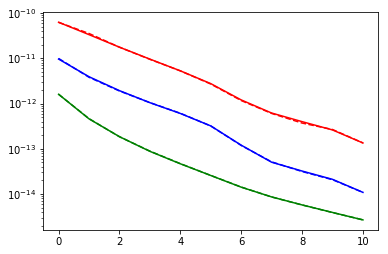

In [1876]:
plt.plot(np.diag(c5se),c='r')
plt.plot(np.diag(c4se),c='b')
plt.plot(np.diag(c3se),c='g')
plt.plot(np.diag(c5seo),c='r',ls='--')
plt.plot(np.diag(c4seo),c='b',ls='--')
plt.plot(np.diag(c3seo),c='g',ls='--')
plt.yscale('log');

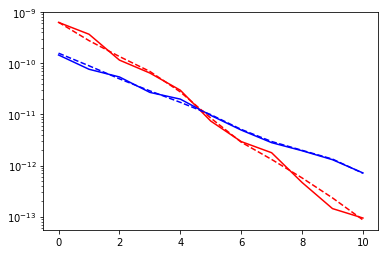

In [1877]:
plt.plot((np.diag(c60_old)),c='r')
plt.plot(-(np.diag(c60_old)),c='r',alpha=0.4)
plt.plot(np.diag(c61_old),c='b')
plt.plot((np.diag(c60_new)),c='r',ls='--')
plt.plot(-(np.diag(c60_new)),c='r',ls='--',alpha=0.4)
plt.plot(np.diag(c61_new),c='b',ls='--')
plt.yscale('log');

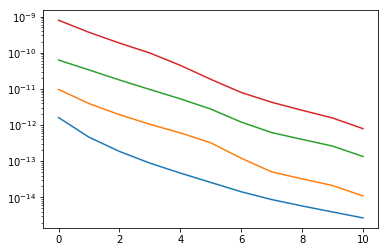

In [1878]:
plt.plot(np.diag(c3se))
plt.plot(np.diag(c4se))
plt.plot(np.diag(c5se))
plt.plot(np.diag(c6se))
plt.plot(-np.diag(c6se),ls='--')
plt.yscale('log')

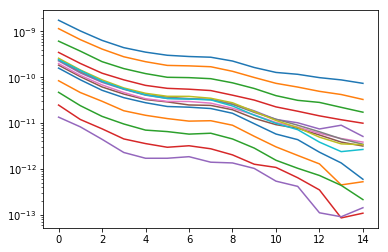

In [1879]:
sym_mat = symmetrize(c60)
for i in range(15):
    plt.plot(sym_mat[9*15+i,:15])
plt.yscale('log')

(0, 100)

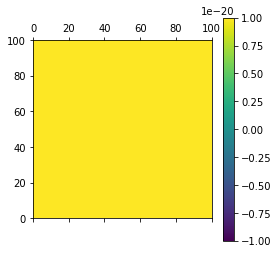

In [1880]:
plt.matshow(sym_mat,vmax=1e-20,vmin=-1e-20)
plt.colorbar();
plt.xlim([0,100])
plt.ylim([0,100])

In [1881]:
input_xi = np.loadtxt('/mnt/store1/oliverphilcox/QPM_xi/QPM_mean.xi',skiprows=2)
xi_r = np.genfromtxt('/mnt/store1/oliverphilcox/QPM_xi/QPM_mean.xi',max_rows=1)

In [1882]:
mu_int_xi_r = np.sum(input_xi,axis=1)*1./input_xi.shape[1]

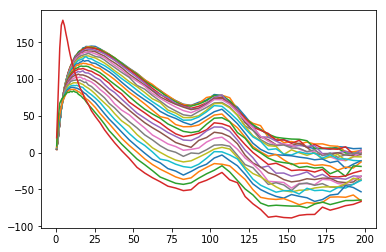

In [1883]:
for i in range(24):
    plt.plot(xi_r,input_xi[:,i]*xi_r**2)

In [1884]:
from scipy.interpolate import interp2d,interp1d
xi_mu = np.arange(0.,1.,1./input_xi.shape[1])
interp=interp2d(xi_r,xi_mu,input_xi.T)
r_max = max(xi_r)
r_min = min(xi_r)

def xi_interp(r,mu,m=4):
    if r>r_max:
        return interp(r_max,mu)*pow(r/r_max,-m)
    elif r<r_min:
        return interp(r_min,mu)
    else:
        return interp(r,mu)

interp_r = interp1d(xi_r,input_xi.mean(axis=1))
def xi_interp_r(r,m=4):
    if r>r_max:
        return interp_r(r_max)*pow(r/r_max,-m)
    elif r<r_min:
        return interp_r(r_min)
    else:
        return interp_r(r)

In [1885]:
r_all = np.arange(0.,1000.,1)

In [1886]:
def integ_xi(m,r_max=400):
    xis = np.array([xi_interp_r(rr,m=m) for rr in r_all[r_all<r_max]])
    return np.sum(r_all[r_all<r_max]**2*xis)*(r_all[1]-r_all[0])

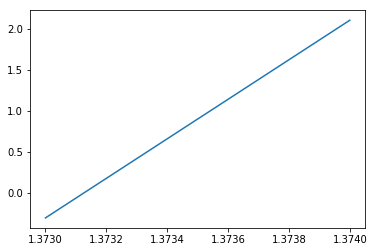

In [1887]:
m_all = np.arange(1.373,1.374,0.001)
integs=[integ_xi(mm) for mm in m_all]
plt.plot(m_all,integs)

In [1888]:
np.where(r_all>400)[0][0]

401

In [1889]:
xis.shape

(1000,)

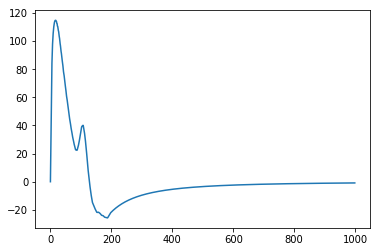

In [1890]:
xis = np.array([float(xi_interp_r(rr)) for rr in r_all])
plt.plot(r_all,r_all**2*xis)

In [1891]:
integs = [np.sum(r_all[:n]**2*xis[:n]) for n in range(1000)]

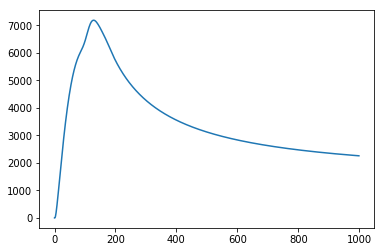

In [1892]:
plt.plot(r_all,integs)

In [1893]:
input_xi.shape

(59, 24)

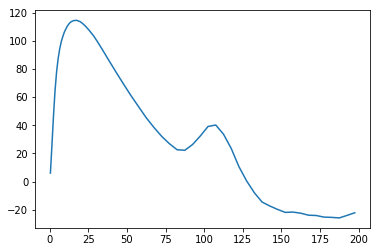

In [1894]:
plt.plot(xi_r,mu_int_xi_r*xi_r**2)

In [1895]:
xi_int = lambda n: np.sum(xi_r[:n]**2*mu_int_xi_r[:n])*(xi_r[1]-xi_r[0])

In [1896]:
ints = [xi_int(n) for n in range(100)]

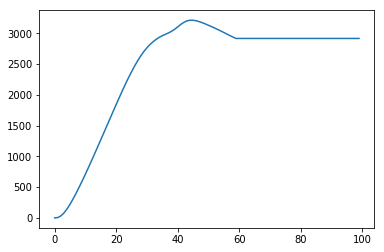

In [1897]:
plt.plot(ints)

In [1898]:
bins_r[4,0]

70.0

In [1899]:
def r2xi_model(r,R_max=400):
    if r<20:
        return 6.*r
    if r<160:
        return 120-(r-20.)*1.5
    if r<R_max:
        m=-90./(160.-R_max)
        return -90.+m*(r-160.)
    else:
        return 0.

In [1900]:
120-140*1.5

-90.0

(0, 200)

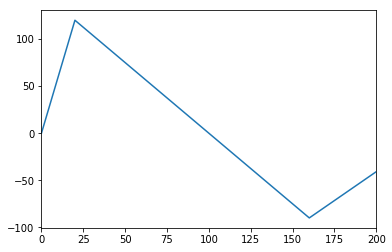

In [1901]:
r2xis = [r2xi_model(rr,R_max=233.3) for rr in r_all]
plt.plot(r_all,r2xis)
plt.xlim([0,200])

In [1902]:
this_r = np.arange(0.1,300,1.)
r2xis = [r2xi_model(rr,R_max=233.3) for rr in this_r]
xi1=np.asarray(r2xis)/this_r**2
this_mu = np.linspace(0,1.,24)

In [1903]:
xi_out=np.vstack([xi1 for _ in range(24)]).T

In [1904]:
outfile = '/mnt/store1/oliverphilcox/3PCF_SE/xi_test.xi'
with open(outfile,"w") as out:
    for i in range(len(this_r)):
        if i<len(this_r)-1:
            out.write("%.6e\t"%this_r[i])
        else:
            out.write("%.6e\n"%this_r[i])
    for j in range(len(this_mu)):
        if j<len(this_mu)-1:
            out.write("%.6e\t"%this_mu[j])
        else:
            out.write("%.6e\n"%this_mu[j])
    for i in range(len(this_r)):
        for j in range(len(this_mu)):
            out.write("%.6e"%(xi_out[i,j]))
            if j<len(this_mu)-1:
                out.write("\t")
            else:
                out.write("\n")

In [1905]:
np.genfromtxt('/mnt/store1/oliverphilcox/3PCF_SE/xi_test.xi',max_rows=1,skip_header=1)

array([0.        , 0.04347826, 0.08695652, 0.1304348 , 0.173913  ,
       0.2173913 , 0.2608696 , 0.3043478 , 0.3478261 , 0.3913043 ,
       0.4347826 , 0.4782609 , 0.5217391 , 0.5652174 , 0.6086957 ,
       0.6521739 , 0.6956522 , 0.7391304 , 0.7826087 , 0.826087  ,
       0.8695652 , 0.9130435 , 0.9565217 , 1.        ])

In [1906]:
np.loadtxt('/mnt/store1/oliverphilcox/3PCF_SE/xi_test.xi',skiprows=2)[this_r>100]

array([[-1.497004e-05, -1.497004e-05, -1.497004e-05, ..., -1.497004e-05,
        -1.497004e-05, -1.497004e-05],
       [-1.614290e-04, -1.614290e-04, -1.614290e-04, ..., -1.614290e-04,
        -1.614290e-04, -1.614290e-04],
       [-3.021754e-04, -3.021754e-04, -3.021754e-04, ..., -3.021754e-04,
        -3.021754e-04, -3.021754e-04],
       ...,
       [ 0.000000e+00,  0.000000e+00,  0.000000e+00, ...,  0.000000e+00,
         0.000000e+00,  0.000000e+00],
       [ 0.000000e+00,  0.000000e+00,  0.000000e+00, ...,  0.000000e+00,
         0.000000e+00,  0.000000e+00],
       [ 0.000000e+00,  0.000000e+00,  0.000000e+00, ...,  0.000000e+00,
         0.000000e+00,  0.000000e+00]])

In [1907]:
test=np.loadtxt('/home/oliverphilcox/COMAJE/test_xi')

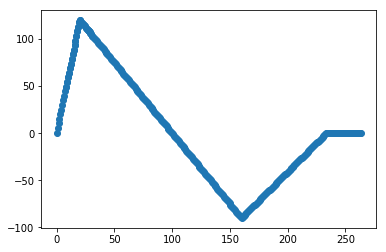

In [1908]:
plt.scatter(test[:,0],test[:,1]*test[:,0]**2)

In [1909]:
xi1[this_r<111]

array([ 6.00000000e+01,  5.45454545e+00,  2.85714286e+00,  1.93548387e+00,
        1.46341463e+00,  1.17647059e+00,  9.83606557e-01,  8.45070423e-01,
        7.40740741e-01,  6.59340659e-01,  5.94059406e-01,  5.40540541e-01,
        4.95867769e-01,  4.58015267e-01,  4.25531915e-01,  3.97350993e-01,
        3.72670807e-01,  3.50877193e-01,  3.31491713e-01,  3.14136126e-01,
        2.96651073e-01,  2.65829608e-01,  2.39245716e-01,  2.16169112e-01,
        1.96019352e-01,  1.78330503e-01,  1.62725151e-01,  1.48895031e-01,
        1.36586416e-01,  1.25588975e-01,  1.15727199e-01,  1.06853734e-01,
        9.88441494e-02,  9.15928113e-02,  8.50095888e-02,  7.90172158e-02,
        7.35491594e-02,  6.85478891e-02,  6.39634613e-02,  5.97523564e-02,
        5.58765182e-02,  5.23025556e-02,  4.90010776e-02,  4.59461351e-02,
        4.31147516e-02,  4.04865266e-02,  3.80432993e-02,  3.57688615e-02,
        3.36487135e-02,  3.16698537e-02,  2.98205983e-02,  2.80904255e-02,
        2.64698406e-02,  

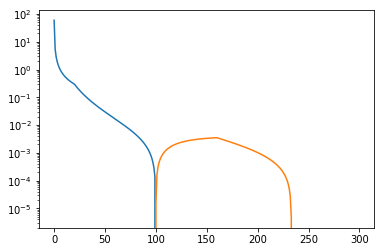

In [1910]:
plt.plot(this_r,xi1)
plt.plot(this_r,-xi1)
plt.yscale('log')

In [1911]:
np.sum(np.asarray(r2xis)[r_all<400])

IndexError: boolean index did not match indexed array along dimension 0; dimension is 300 but corresponding boolean dimension is 1000

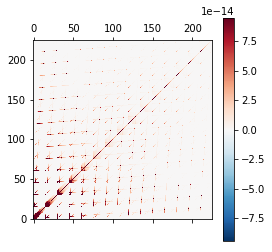

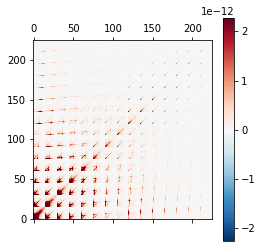

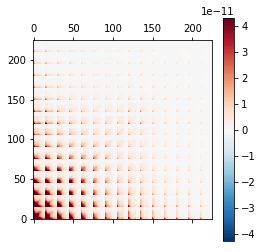

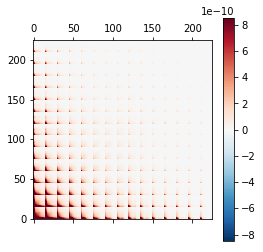

In [1912]:
plotter(rebinner(c3s))
plotter(rebinner(c4s))
plotter(rebinner(c5s))
plotter(rebinner(c6s))

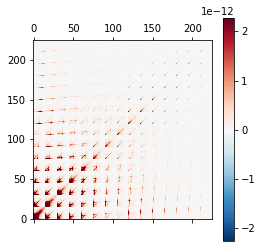

In [1913]:
plotter(rebinner(c4s))

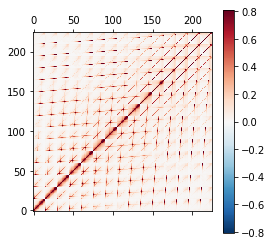

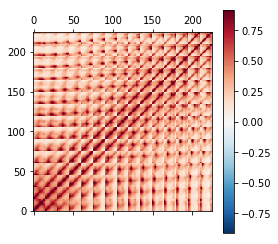

In [1914]:
plotter(reduce(rebinner(c4s)))
plotter(reduce(rebinner(c5s)))

In [1915]:
def reduce(mat):
    out_mat = np.zeros_like(mat)
    for i in range(len(mat)):
        for j in range(len(mat)):
            out_mat[i,j]=mat[i,j]/np.sqrt(mat[i,i]*mat[j,j])
    return out_mat

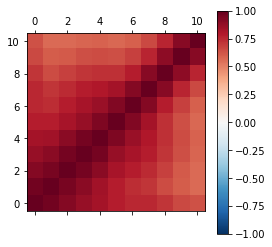

In [1918]:
plotter(reduce(c6se+c5se+c4se+c3se))

**Difference between two C3 estimates**~

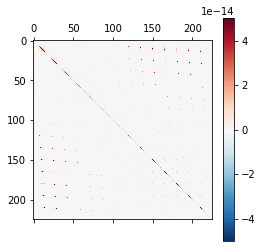

In [1919]:
mat=rebinner(symmetrize(c30-c31))
vmax=np.percentile(rebinner(symmetrize(c30)),99.)
plt.matshow(mat,vmax=vmax,vmin=-vmax,cmap=cm.RdBu_r);
plt.colorbar();

In [1920]:
tot_mat = symmetrize(c3+c4+c5+c6)

## Total Matrix

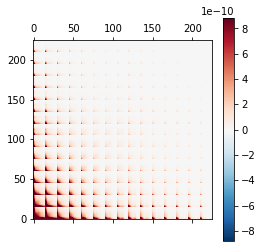

<Figure size 432x288 with 0 Axes>

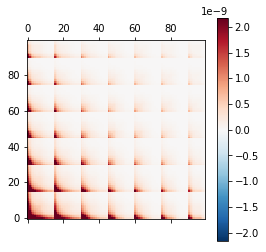

In [1921]:
plotter(rebinner(symmetrize(tot_mat)))
plt.figure()
plotter(rebinner(symmetrize(tot_mat))[:100,:100])

In [1922]:
b30=np.loadtxt(indir+'binct_c3_n%d_l%d_0_full.txt'%(n,l))
b40=np.loadtxt(indir+'binct_c4_n%d_l%d_0_full.txt'%(n,l))
b50=np.loadtxt(indir+'binct_c4_n%d_l%d_0_full.txt'%(n,l))
b60=np.loadtxt(indir+'binct_c4_n%d_l%d_0_full.txt'%(n,l))
b31=np.loadtxt(indir+'binct_c4_n%d_l%d_0_full.txt'%(n,l))
b41=np.loadtxt(indir+'binct_c4_n%d_l%d_0_full.txt'%(n,l))
b51=np.loadtxt(indir+'binct_c5_n%d_l%d_0_full.txt'%(n,l))
b61=np.loadtxt(indir+'binct_c6_n%d_l%d_0_full.txt'%(n,l))

**6-point Sampling**

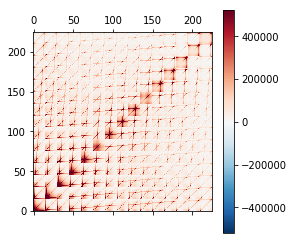

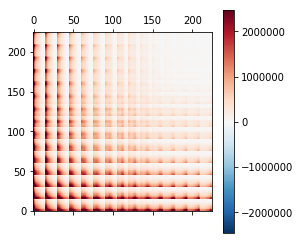

In [1923]:
plotter(rebinner(symmetrize(b60)))
plotter(rebinner(symmetrize(b61)))

**3 Point**

(0, 300)

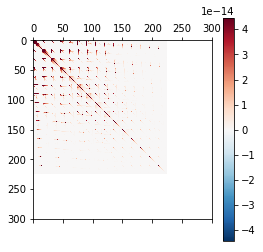

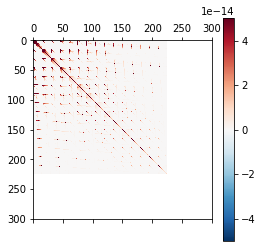

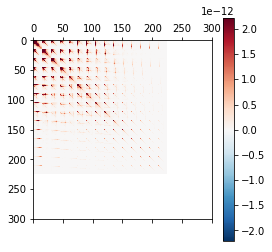

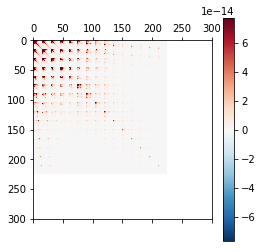

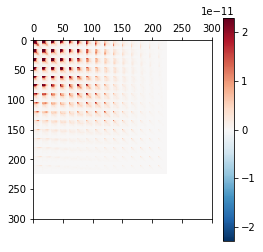

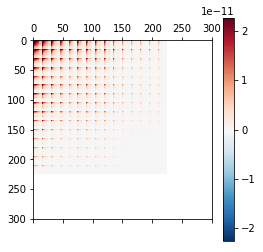

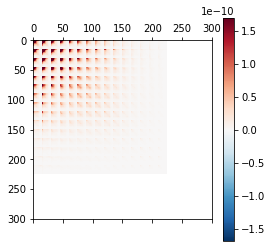

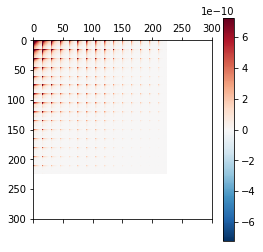

In [1924]:
plotter(rebinner(symmetrize(c31)));plt.ylim([300,0]);plt.xlim([0,300])
plotter(rebinner(symmetrize(c30)));plt.ylim([300,0]);plt.xlim([0,300])
plotter(rebinner(symmetrize(c41)));plt.ylim([300,0]);plt.xlim([0,300])
plotter(rebinner(symmetrize(c40)));plt.ylim([300,0]);plt.xlim([0,300])
plotter(rebinner(symmetrize(c51)));plt.ylim([300,0]);plt.xlim([0,300])
plotter(rebinner(symmetrize(c50)));plt.ylim([300,0]);plt.xlim([0,300])
plotter(rebinner(symmetrize(c61)));plt.ylim([300,0]);plt.xlim([0,300])
plotter(rebinner(symmetrize(c60)));plt.ylim([300,0]);plt.xlim([0,300])

In [1925]:
def collapse_axes(mat,c_bin,d_bin):
    new_mat = np.zeros([m,m,n,n])
    for i in range(len(mat)):
        p_bin = i%m
        a_bin = (i//m)//n
        b_bin = (i//m)%n
        for q_bin in range(m):
            new_mat[p_bin,q_bin,a_bin,b_bin] = mat[i,c_bin*n+d_bin*m+q_bin]
    return new_mat

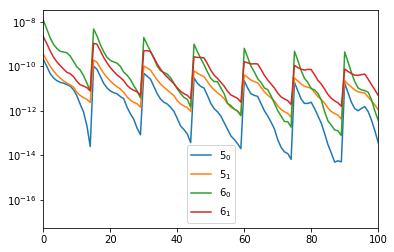

In [1926]:
plt.plot(np.diag(rebinner(symmetrize(c50)))[:n*n],label=r'$5_0$')
plt.plot(np.diag(rebinner(symmetrize(c51)))[:n*n],label=r'$5_1$')
plt.plot(np.diag(rebinner(symmetrize(c60)))[:n*n],label=r'$6_0$')
plt.plot(np.diag(rebinner(symmetrize(c61)))[:n*n],label=r'$6_1$')
plt.legend();plt.xlim([0,100])
plt.yscale('log');

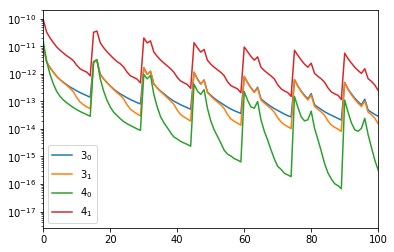

In [1927]:
plt.plot(np.diag(rebinner(symmetrize(c30)))[:n*n],label=r'$3_0$')
plt.plot(np.diag(rebinner(symmetrize(c31)))[:n*n],label=r'$3_1$')
plt.plot(np.diag(rebinner(symmetrize(c40)))[:n*n],label=r'$4_0$')
plt.plot(np.diag(rebinner(symmetrize(c41)))[:n*n],label=r'$4_1$')
plt.legend();plt.xlim([0,100])
plt.yscale('log');

In [1928]:
def variance(mat):
    out_mat = np.zeros([m,n,n])
    for p in range(m):
        for i in range(n):
            for j in range(n):
                out_mat[p,i,j]=mat[(i*n+j)*m+p,(i*n+j)*m+p]
    return out_mat

In [1929]:
collapsed_mat = collapse_axes(tot_mat,5,7)
collapsed_mat.shape

(1, 1, 15, 15)

In [1930]:
def collapse_axes_all_corr(mat,c_bin,d_bin):
    new_mat = np.zeros([n*m,n*m])
    for i in range(len(mat)):
        p_bin = i%m
        a_bin = (i//m)//n
        b_bin = (i//m)%n
        for q_bin in range(m):
            new_mat[p_bin*n+a_bin,q_bin*n+b_bin] += mat[i,c_bin*n*m+d_bin*m+q_bin]
    # Now compute correlation matrix
    corr_mat = np.zeros([n*m,n*m])
    for i in range(len(corr_mat)):
        p_bin = i//n
        a_bin = i%n
        for j in range(len(corr_mat[0])):
            q_bin = j//n
            b_bin = j%n
            corr_mat[p_bin*n+a_bin,q_bin*n+b_bin]=new_mat[p_bin*n+a_bin,q_bin*n+b_bin]/np.sqrt(new_mat[p_bin*n+a_bin,q_bin*n+a_bin]*new_mat[p_bin*n+b_bin,q_bin*n+b_bin])
    return corr_mat

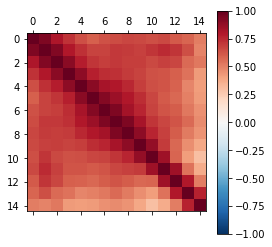

In [1931]:
collapsed_mat = collapse_axes_all_corr(tot_mat,5,7)
vmax=np.percentile(collapsed_mat,99.9)
plt.matshow(collapsed_mat,vmax=vmax,vmin=-vmax,cmap=cm.RdBu_r);
#plt.title(r'$C_{%d%d}$'%(2*i,2*j))
plt.colorbar();

IndexError: index 1 is out of bounds for axis 1 with size 1

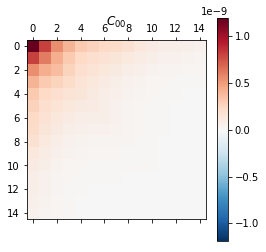

In [1932]:
collapsed_mat = collapse_axes(tot_mat,5,2)
for i in range(3):
    for j in range(3):
        vmax=np.percentile(collapsed_mat[i,j],99.9)
        plt.matshow(collapsed_mat[i,j],vmax=vmax,vmin=-vmax,cmap=cm.RdBu_r);
        plt.title(r'$C_{%d%d}$'%(2*i,2*j))
        plt.colorbar();